# Lorenzo Cassano 
Task: 
- use a method of clustering (preprocessing include)
- find the best hyperparameters
- compute the confusion matrix and the accuracy
- try to find the best clustering scheme that reproduce the column y

## Importing Libraries

In [84]:

import warnings
warnings.filterwarnings('ignore') # uncomment this line to suppress warnings
import seaborn as sns
import pandas as pd
import numpy as np
from math import sqrt
#from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.metrics import pair_confusion_matrix
from matplotlib import cm
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import pair_confusion_matrix
random_state = 42

In [140]:
def plot_clusters(X, y, dim, points,
                  labels_prefix = 'cluster', 
                  points_name = 'centroids',
                  colors = cm.tab10, # a qualitative map 
                      # https://matplotlib.org/examples/color/colormaps_reference.html
#                   colors = ['brown', 'orange', 'olive', 
#                             'green', 'cyan', 'blue', 
#                             'purple', 'pink'],
#                   points_color = 'red'
                  points_color = cm.tab10(10) # by default the last of the map (to be improved)
                 ):
    """
    Plot a two dimensional projection of an array of labelled points
    X:      array with at least two columns
    y:      vector of labels, length as number of rows in X
    dim:    the two columns to project, inside range of X columns, e.g. (0,1)
    points: additional points to plot as 'stars'
    labels_prefix: prefix to the labels for the legend ['cluster']
    points_name:   legend name for the additional points ['centroids']
    colors: a color map
    points_color: the color for the points
    """
    # plot the labelled (colored) dataset and the points
    labels = np.unique(y)
    for i in range(len(labels)):
        color = colors(i / len(labels)) # choose a color from the map
        plt.scatter(X[y==labels[i],dim[0]], 
                    X[y==labels[i],dim[1]], 
                    s=10, 
                    c = [color], # scatter requires a sequence of colors
                    marker='s', 
                    label=labels_prefix+str(labels[i]))
    plt.scatter(points[:,dim[0]], 
                points[:,dim[1]], 
                s=50, 
                marker='*', 
                c=[points_color], 
                label=points_name)
    plt.legend()
    plt.grid()
    plt.show()

In [141]:
def compute_centroids(X, y, n_clusters):
  centroids = np.empty((n_clusters, X.shape[1]))
  for i in range(0, n_clusters):
    centroids[i, :] = np.mean(X[y == i], axis = 0)
  return centroids

## Load dataset

In [85]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [86]:

url = '/content/drive/MyDrive/ML/Data/seeds_dataset.txt'
df = pd.read_csv(url, sep = '\t',names = ['A','B','C','D','E','F','G','H'])
df.head()

,A,B,C,D,E,F,G,H
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,0
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,0
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,0
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,0
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,0


In [87]:
target = 'H'
X = df.drop(target, axis = 1)
y = df[target]

### Some description

In [88]:
X.describe()

,A,B,C,D,E,F,G
count,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000
mean,14.847524,14.559286,0.870999,5.628533,3.258605,3.700201,5.408071
std,2.909699,1.305959,0.023629,0.443063,0.377714,1.503557,0.491480
min,10.590000,12.410000,0.808100,4.899000,2.630000,0.765100,4.519000
25%,12.270000,13.450000,0.856900,5.262250,2.944000,2.561500,5.045000
50%,14.355000,14.320000,0.873450,5.523500,3.237000,3.599000,5.223000
75%,17.305000,15.715000,0.887775,5.979750,3.561750,4.768750,5.877000
max,21.180000,17.250000,0.918300,6.675000,4.033000,8.456000,6.550000


In [89]:
y.describe()

count    210.000000
mean       1.000000
std        0.818448
min        0.000000
25%        0.000000
50%        1.000000
75%        2.000000
max        2.000000
Name: H, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd6a4226ca0>,
      dtype=object)

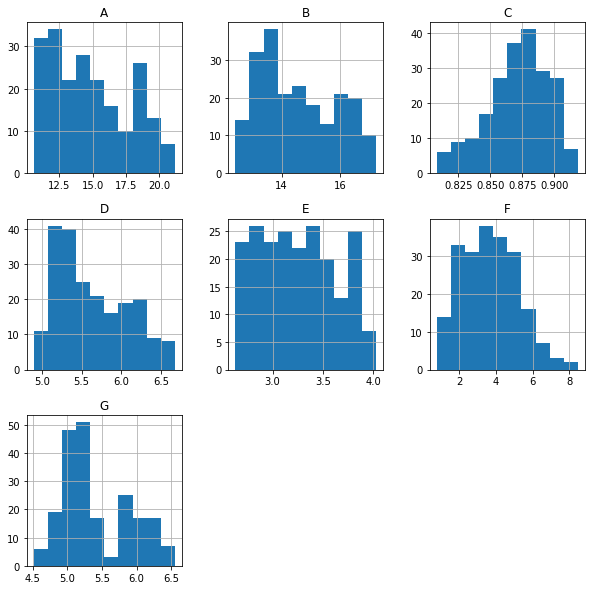

In [90]:
X.hist(figsize = [10,10])

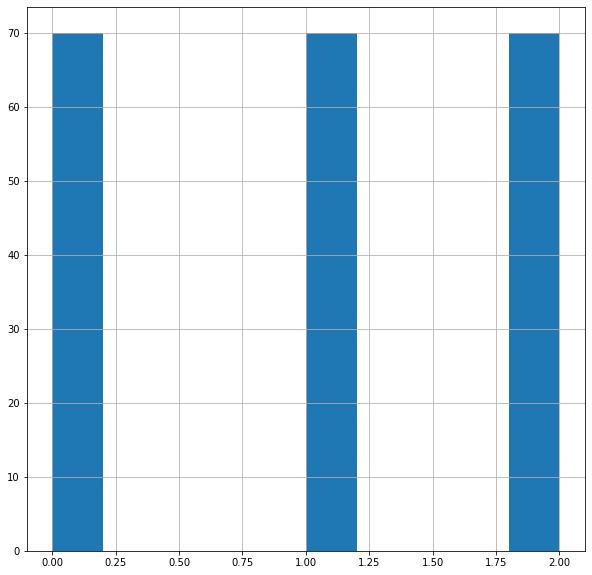

In [91]:
y.hist(figsize = [10,10])

### pairplot

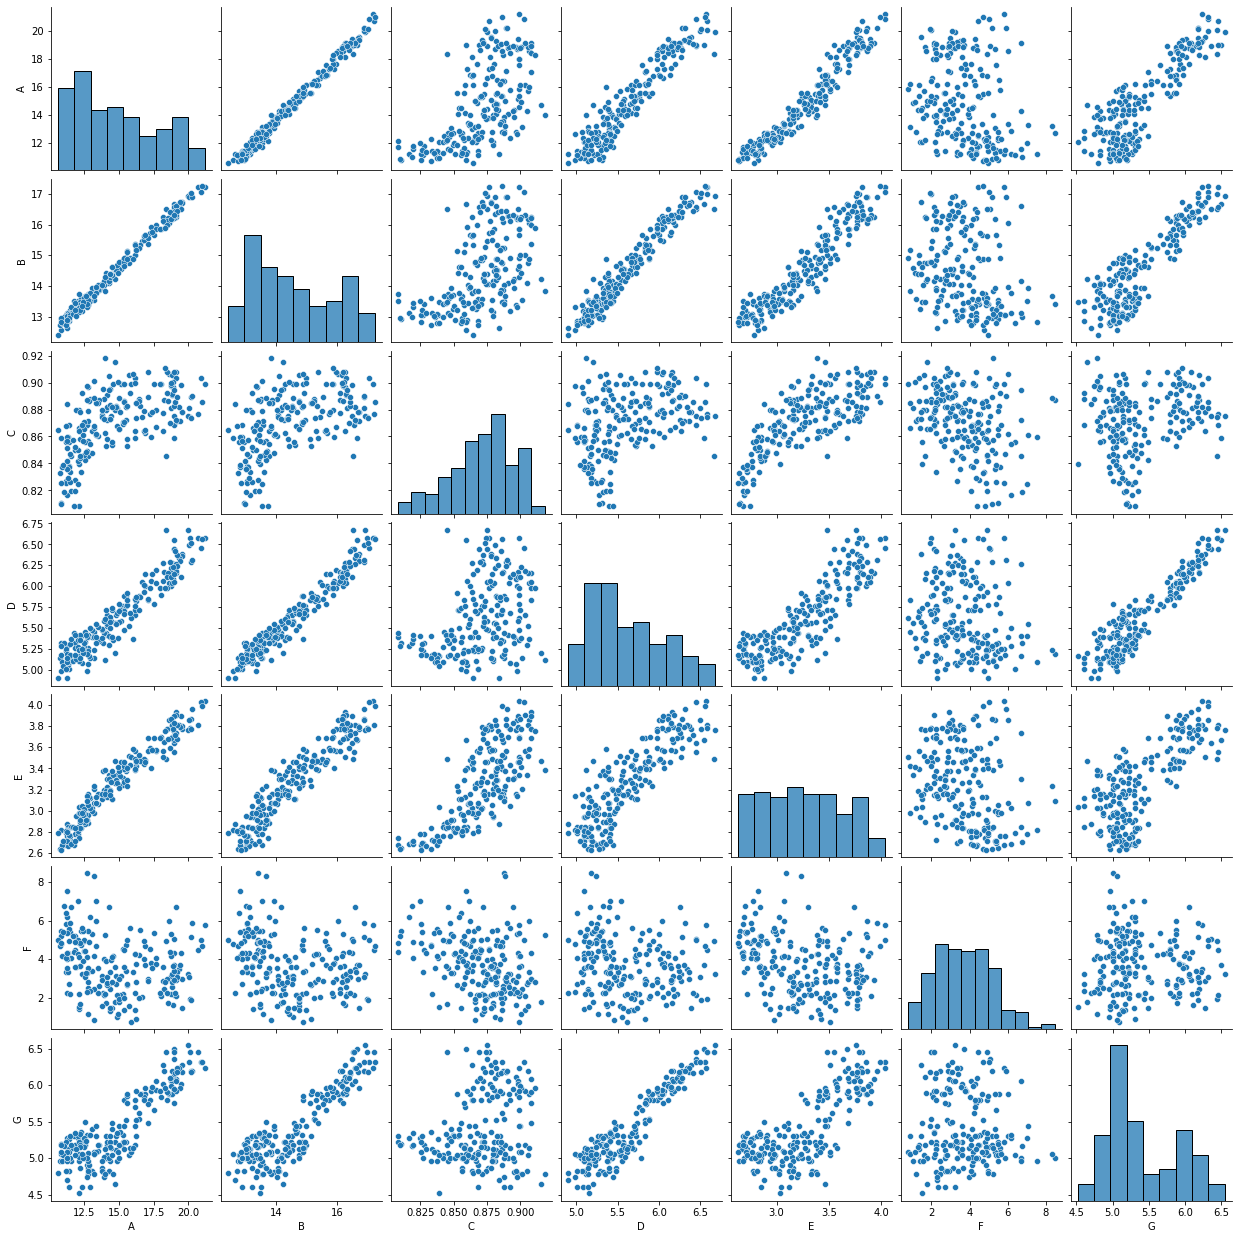

In [92]:
sns.pairplot(X)

We observe that the distributions of values are definitely skewed: in this cloumns we need a rescale operation for better performance.

## Preprocessing

In [93]:
# square root transformation - the first two columns are not transformed

X_sqrt = pd.concat([X.iloc[:,:2].applymap(sqrt), X.iloc[:,2], X.iloc[:,3:].applymap(sqrt)], axis=1)

# remap on the 0:1 range with MinMaxScaler

minMax = MinMaxScaler()
X_scale = pd.DataFrame(minMax.fit_transform(X_sqrt), columns = X_sqrt.columns)
X_scale.head()
     

,A,B,C,D,E,F,G
0,0.483830,0.522560,0.570780,0.505779,0.512703,0.302772,0.366637
1,0.447520,0.466726,0.662432,0.387118,0.527607,0.066033,0.231633
2,0.390211,0.366172,0.879310,0.234579,0.530441,0.377806,0.163308
3,0.345702,0.334399,0.793103,0.253923,0.560091,0.309016,0.152795
4,0.566220,0.553359,0.864791,0.446439,0.687179,0.142309,0.343870


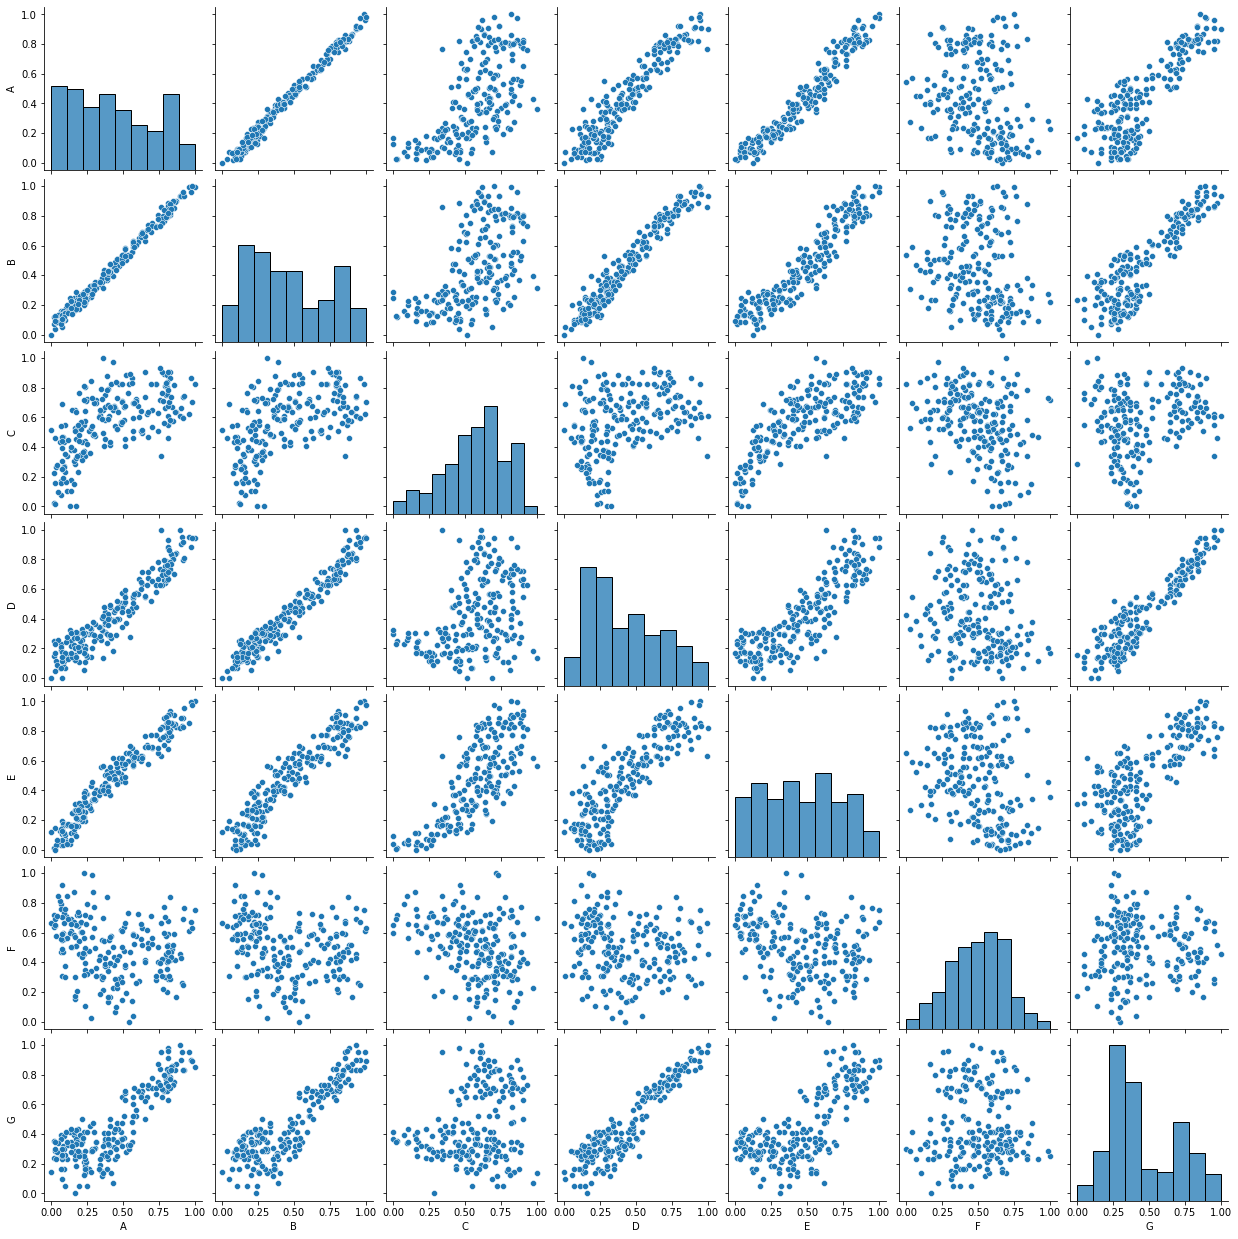

In [94]:
X = X_scale
sns.pairplot(X)

## First method choosen is k_means

In [95]:
def computing_best_clustering(X, k_range):
  #k_range = range(2,11) # set the range of k values to test 
  inertias = []
  silhouettes = []
  for i in k_range:
    k_model = KMeans(n_clusters = i, random_state = random_state)
    y_find = k_model.fit_predict(X)
    silhouette = silhouette_score(X, y_find)
    inertias.append(k_model.inertia_)
    silhouettes.append(silhouette)
  return inertias,silhouettes
     

In [96]:
def two_plots(x, y1, y2, xlabel, y1label, y2label):
    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(y1label, color=color)
    ax1.plot(x, y1, color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel(y2label, color=color)  # we already handled the x-label with ax1
    ax2.plot(x, y2, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylim(0,1) # the axis for silhouette is [0,1]

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

In [97]:
k_range = list(range(2,11))
inertias, silhouettes = computing_best_clustering(X, k_range)

## Choice of Number of clusters

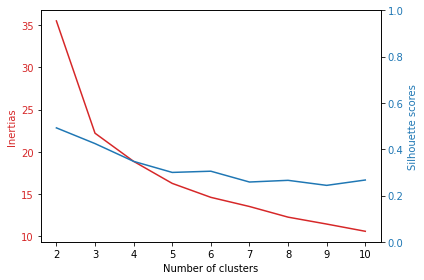

In [98]:
two_plots(x=k_range, y1=inertias, y2=silhouettes
          , xlabel='Number of clusters', y1label='Inertias', y2label='Silhouette scores'
         )

The coice is not trival: the elbow plot shows a great  change of slope in 2 and 3

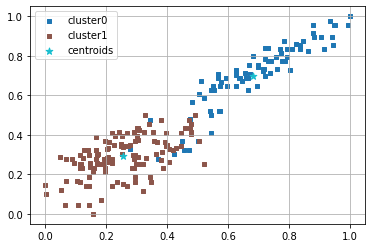

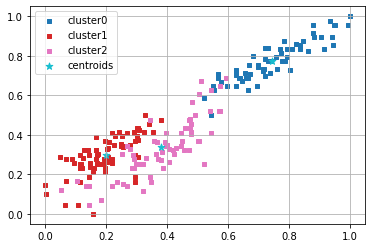

In [142]:
focus = [3,6] # most rappresentative column
best_k = [2,3]
X1 = np.array(X)
for k in best_k:

    best = KMeans(n_clusters = k, random_state = random_state)
    best.fit_predict(X)
    y_km = best.labels_
    
    centroids_dataset = compute_centroids(X, y_km, n_clusters = k)

    plot_clusters(X1, y_km, dim=(focus[0],focus[1]), points = centroids_dataset)

With k = 3 seem to be better

In [99]:
k = 3
model =  KMeans(n_clusters= k, random_state = random_state)
y_km = model.fit_predict(X)
print("Number of clusters {}, Inertia {:6.2f}, Silhouette {:4.2f}".format(k,inertias[k_range.index(k)],silhouettes[k_range.index(k)]))

Number of clusters 3, Inertia  22.20, Silhouette 0.42


## Gold standard

In [100]:
pcm = pair_confusion_matrix(y, y_km)
print("Confusion Matrix")
print(pcm / pcm.sum())

Confusion Matrix
[[0.60350877 0.06634769]
 [0.06438824 0.2657553 ]]


In [101]:
print("The percentage of match between the two clustering schemes is {:6.2f}%".format((pcm / pcm.sum()).diagonal().sum()*100))

The percentage of match between the two clustering schemes is  86.93%


## Try to find the best clustering scheme
Observing the previous k_means, we had to use as number of cluster = 3 which is the numbe of cluster in y
The dataset does not seem with concavity but we try to use dbscan and agglomerative clustering to find the best clustering scheme

## Plot the point of the dataset

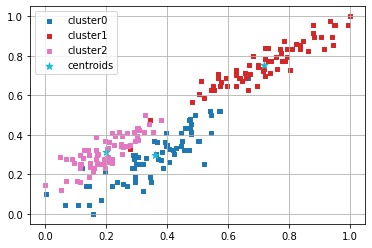

In [104]:

centroids_dataset = compute_centroids(X, y, n_clusters = k)
#X1 = np.array(X)
plot_clusters(X1, y, dim=(focus[0],focus[1]), points = centroids_dataset)

As accuracy said the kmeans has a good performance

## Try to use dbscan

In [110]:
tuned_param_dbbscan = {'eps': list(np.arange(0.01, 1, 0.01)), 'min_samples': list(range(1,10)) }
params = list(ParameterGrid(tuned_param_dbbscan))
X1 = X1[:,focus]

In [111]:
dbscan_out = pd.DataFrame(columns =  ['eps','min_samples','n_clusters','silhouette', 'unclust%'])
for i in range(len(params)):
    db = DBSCAN(**(params[i]))
    y_find = db.fit_predict(X1)
    
    cluster_labels_noise = np.unique(y_find)
    cluster_labels = cluster_labels_noise[cluster_labels_noise != -1]
    n_clusters = len(cluster_labels)

    if n_clusters > 1:
        X_cl = X1[y_find != -1, :]
        y_find_cl = y_find[y_find != -1]
       
        silhouette = silhouette_score(X_cl, y_find_cl)
        uncl_p = (1 - y_find_cl.shape[0] / y_find.shape[0]) * 100
        dbscan_out.loc[len(dbscan_out)] = [db.eps, db.min_samples, n_clusters, silhouette, uncl_p]

In [120]:
sil_thr = 0.4  # visualize results only for combinations with silhouette above the threshold
unc_thr = 10 # visualize results only for combinations with unclustered% below the threshold
n_max_clusters = 3
#dbscan_out[(dbscan_out['silhouette'] >= sil_thr) & (dbscan_out['unclust%'] <= unc_thr)]
dbscan_out[(dbscan_out['silhouette'] >= sil_thr) & \
          (dbscan_out['unclust%'] <= unc_thr) & \
          (dbscan_out['n_clusters'] == n_max_clusters)]

,eps,min_samples,n_clusters,silhouette,unclust%
37,0.06,2.0,3.0,0.432386,0.47619
38,0.06,3.0,3.0,0.432386,0.47619


Choice is equal to eps = 0.06 and min_samples = 2

In [124]:

min_eps = 0.06
samples = 2
dbscan_model = DBSCAN(eps= min_eps, min_samples= samples)
y_dbscan = dbscan_model.fit_predict(X1)
n_clusters = len(cluster_labels)
cluster_labels_noise = np.unique(y_dbscan)
cluster_labels = cluster_labels_noise[cluster_labels_noise != -1]
centroids = compute_centroids(X1, y_dbscan,n_clusters)
print("There are {} clusters ".format(n_clusters))


There are 3 clusters 


## Plotting cluster dbscan

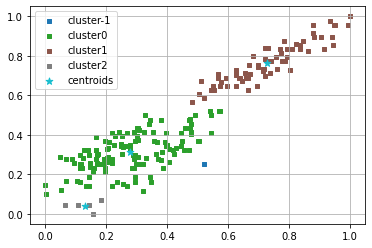

In [127]:

centroids = compute_centroids(X, y_dbscan, n_clusters = k)
plot_clusters(np.array(X), y_dbscan, dim=(focus[0],focus[1]), points = centroids)

We can observe that the Dbscan performance are not good
## Try to use agglomerative

In [128]:
df_result = pd.DataFrame(columns =  ['linkage','n_clusters','silhouette_score'])

tuned_param = [{'n_clusters' : k_range, 'linkage' : ['ward', 'complete', 'average', 'single']}]
param = list(ParameterGrid(tuned_param))

for i in range(0, len(param)):
  aggl_model = AgglomerativeClustering(**(param[i]))
  y_find = aggl_model.fit_predict(X)
  silhouette = silhouette_score(X, y_find)
  df_result.loc[len(df_result)] = [aggl_model.linkage, aggl_model.n_clusters, silhouette]

In [129]:
df_result.sort_values(by='silhouette_score', ascending=False).head(5)

,linkage,n_clusters,silhouette_score
0,ward,2,0.501742
9,complete,2,0.500155
18,average,2,0.487182
10,complete,3,0.415220
19,average,3,0.397433


Linkage used is "complete"

In [130]:
ac = AgglomerativeClustering(n_clusters=3, linkage='ward')
y_ac = ac.fit_predict(X)

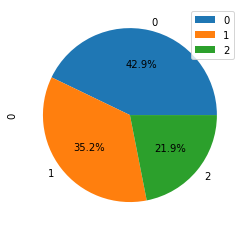

In [131]:
clust_sizes_ac = np.unique(y_ac,return_counts=True)
pd.DataFrame(clust_sizes_ac[1]).plot.pie(y=0, autopct='%1.1f%%', );
plt.show()

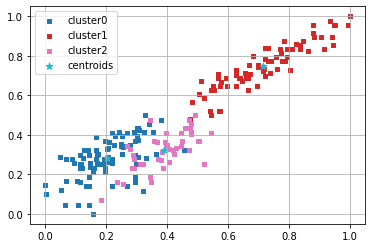

In [132]:
centroids = compute_centroids(X, y_ac, n_clusters = k)
plot_clusters(np.array(X), y_ac, dim=(focus[0],focus[1]), points = centroids)

From the plot the agglomerative clustering seems to have good performance
### Try to compute Confusion matrix and accuracy

In [133]:
pcm = pair_confusion_matrix(y, y_ac)
print("Confusion Matrix")
print(pcm / pcm.sum())

Confusion Matrix
[[0.58345865 0.08639781]
 [0.06379585 0.26634769]]


In [134]:
print("The percentage of match between the two clustering schemes is {:6.2f}%".format((pcm / pcm.sum()).diagonal().sum()*100))

The percentage of match between the two clustering schemes is  84.98%


In conclusion the best model to replicate y is the KMeans